In [1]:
import sys
sys.path.append('../')

import numpy as np
import scipy
import tqdm
import utils
import geometry
from phantom import Phantom
from tissue import Tissue
from transducer import Transducer, Focused, Planewave
from transducer_set import TransducerSet
from simulation import SimProperties, Simulation
from sensor import Sensor
from experiment import Experiment
from reconstruction import Reconstruction

import matplotlib.pyplot as plt

import kwave
import glob
import plotly.express as px
import SimpleITK as sitk

# Initialize single transducers

Focused transducers must have a finite focal length. Consider instantiating a plane-wave transducer if you require infinite focal length.
Focused transducers must have a finite focal length. Consider instantiating a plane-wave transducer if you require infinite focal length.


NameError: name 'phantom' is not defined

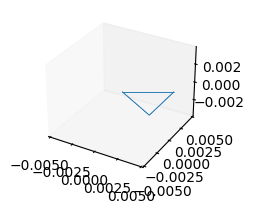

In [2]:
transducer_3d = Focused(
                 label = None,
                 max_frequency = 2e6,
                 source_strength = 1e6,
                 cycles = 2,
                 elements = 32,
                 active_elements = None,
                 element_width = 1e-4,
                 elevation = 1e-4 * 32,
                 kerf = 0,
                 radius = float('inf'),
                 focus_azimuth = float('inf'), # PW by default
                 focus_elevation = float('inf'),
                 sensor_sampling_scheme = 'not_centroid',
                 sweep = (np.pi/3,np.pi/3),
                 ray_num = (64,64),
                 imaging_ndims = 3, # should be 2 or 3
                 transmit_apodization = 'tukey75',
                 receive_apodization = 'boxcar',
                 harmonic = 1,
                 bandwidth = 100,
                 compression_fac = None,
                 normalize = True,
                 )

transducer_2d = Focused(
                 label = None,
                 max_frequency = 2e6,
                 source_strength = 1e6,
                 cycles = 2,
                 elements = 32,
                 active_elements = None,
                 element_width = 1e-4,
                 elevation = 1e-4 * 32,
                 kerf = 0,
                 radius = float('inf'),
                 focus_azimuth = float('inf'), # PW by default
                 focus_elevation = float('inf'),
                 sensor_sampling_scheme = 'not_centroid',
                 sweep = np.pi/3,
                 ray_num = 64,
                 imaging_ndims = 2, # should be 2 or 3
                 transmit_apodization = 'tukey75',
                 receive_apodization = 'boxcar',
                 harmonic = 1,
                 bandwidth = 100,
                 compression_fac = None,
                 normalize = True,
                 )


scale = 0.005
fig = plt.figure(figsize=plt.figaspect(0.7))

rays = transducer_2d.make_ray_transforms(2, np.pi/3, 64)
ax = fig.add_subplot(2, 2, 1, projection='3d')
transducer_2d.plot_fov(scale=.01, ax=ax)
ax.grid(False)
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_zlim(-scale, scale)
ax.set_aspect('equal')
transducer_2d.make_sensor_coords(phantom.baseline[0])
ax = fig.add_subplot(2, 2, 2, projection='3d')
transducer_2d.plot_sensor_coords(ax=ax)
ax.grid(False)
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_zlim(-scale, scale)
ax.set_aspect('equal')

rays = transducer_3d.make_ray_transforms(2, np.pi/3, 64)
ax = fig.add_subplot(2, 2, 3, projection='3d')
transducer_3d.plot_fov(scale=.01, ax=ax)
ax.grid(False)
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_zlim(-scale, scale)
ax.set_aspect('equal')
transducer_3d.make_sensor_coords(phantom.baseline[0])
ax = fig.add_subplot(2, 2, 4, projection='3d')
transducer_3d.plot_sensor_coords(ax=ax)
ax.grid(False)
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_zlim(-scale, scale)
ax.set_aspect('equal')
plt.show()

# Create transducer set

In [3]:
transducers = [Focused(elements = 32, 
                       elevation = 1e-4 * 32, 
                       sensor_sampling_scheme = 'not_centroid', 
                       sweep = (np.pi/8,np.pi/8), 
                       ray_num = (32,32), 
                       imaging_ndims = 3,
                       focus_azimuth = 20e-3,
                       focus_elevation = 20e-3,
                       ) for i in range(4)]
# transducers = [Focused(elements = 32, 
#                        elevation = 1e-4 * 32, 
#                        sensor_sampling_scheme = 'not_centroid', 
#                        sweep = np.pi/3, 
#                        ray_num = 128, 
#                        imaging_ndims = 2,
#                        focus_azimuth = 30e-3,
#                        focus_elevation = 30e-3,
#                        ) for i in range(1)]

for t in transducers:
    t.make_sensor_coords(phantom.baseline[0])

NameError: name 'phantom' is not defined

# Generate transducer extrinsics

In [4]:
transducer_set = TransducerSet(transducers, seed=0000)
transducer_set.generate_extrinsics(shape="spherical", extrinsics_kwargs={'r_mean': 0.03, 'view_std': 0, 'yaw_fraction': 1, 'pitch_fraction': 0, 'roll_fraction': 0})
# transducer_set.generate_extrinsics(shape="cylindrical", extrinsics_kwargs={'r_mean': 0.02,})
# transducer_set.generate_extrinsics(shape='bleh', extrinsics_kwargs={'size': 0.002,})


# Plot transducer poses and fov

In [ ]:
fig = plt.figure(figsize=plt.figaspect(0.5))
scale = 0.02

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_proj_type('ortho')
ax.grid(False)
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_zlim(-scale, scale)
ax.set_aspect('equal')
transducer_set.plot_transducer_coords(scale=0.021, ax=ax)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_proj_type('ortho')
ax.grid(False)
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_zlim(-scale, scale)
ax.set_aspect('equal')
transducer_set.plot_transducer_fovs(scale=0.02, ax=ax)

In [ ]:
import plotly.graph_objects as go

coords = []
for i in range(len(transducer_set.transducers)):
    coords.append(transducer_set.poses[i].apply_to_points(transducer_set.transducers[i].sensor_coords))
    
fig = go.Figure(data=[go.Scatter3d(
                    x=np.concatenate(coords, axis=0)[:,0],
                    y=np.concatenate(coords, axis=0)[:,1],
                    z=np.concatenate(coords, axis=0)[:,2],
                    mode='markers',
                    marker=dict(size=1, opacity=0.8,),
                )])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(scene_aspectmode='data')
fig.show()